# **Near-Earth Close Approach Objects Analysis and Model Training(XGBoost)**

In [1]:
### Step-By-Step Process

### STEP 1: Importing the modules

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

### STEP 2: LOADING the DATA

space_data_v1 = pd.read_csv(r'D:\Pycharm Projects\PycharmProjects\PythonProject\Full Data Pipeline Projects\Near Earth Objects\Hazardous Asteroid Classification XGBoost\Data\Raw Data\Space.csv')                  # Loading and Reading our csv file using pandas.


In [31]:
### STEP 3: EXPLORING THE DATA

space_data_v1.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


In [32]:
space_data_v1.describe()                # Understanding the Data.

,neo_id,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance
count,3.381990e+05,338171.000000,338171.000000,338171.000000,338199.000000,3.381990e+05
mean,1.759939e+07,22.932525,0.157812,0.352878,51060.662908,4.153535e+07
std,2.287225e+07,2.911216,0.313885,0.701869,26399.238435,2.077399e+07
min,2.000433e+06,9.250000,0.000511,0.001143,203.346433,6.745533e+03
25%,3.373980e+06,20.740000,0.025384,0.056760,30712.031471,2.494540e+07
50%,3.742127e+06,22.800000,0.073207,0.163697,47560.465474,4.332674e+07
75%,5.405374e+07,25.100000,0.189041,0.422708,66673.820614,5.933961e+07
max,5.446281e+07,33.580000,37.545248,83.953727,291781.106613,7.479865e+07


In [33]:
space_data_v1.info()      # Checking the information like data types, null values, and size of the dataframe.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB


In [34]:
space_data_v1.isnull().sum()

neo_id                     0
name                       0
absolute_magnitude        28
estimated_diameter_min    28
estimated_diameter_max    28
orbiting_body              0
relative_velocity          0
miss_distance              0
is_hazardous               0
dtype: int64

*As we can observe, our data has 28 rows where the data is either missing or has NaN (NULL values).

We can either drop those rows or we can fill those up with values.

If we wish to drop the rows, we can use **space_data_v1.dropna()**, however, since looking at the criticality of the risk and also ensuring we don't miss out any potentially hazardous asteroids, we can do **space_data_v1.interpolate()**, which will fill out the missing rows with data in logical order, rather than filling it with the average values.

Example, let's say we have data in this manner:

data = **[10, NaN, 30, NaN, 50]**

where NaN = None or Missing data.

Logically, the order should be [10, 20, 30, 40, 50].

So, **dataframe.interpolate()** replaces NaN with values like 20, and 40.

**[10, NaN, 30, NaN, 50]** becomes **[10, 20, 30, 40, 50]**

In [35]:
### STEP 4: Cleaning the DATA

space_data_v1['absolute_magnitude'] = space_data_v1['absolute_magnitude'].interpolate()

space_data_v1['estimated_diameter_min'] = space_data_v1['estimated_diameter_min'].interpolate()
space_data_v1['estimated_diameter_max'] = space_data_v1['estimated_diameter_max'].interpolate()

print(space_data_v1.isnull().sum())

neo_id                    0
name                      0
absolute_magnitude        0
estimated_diameter_min    0
estimated_diameter_max    0
orbiting_body             0
relative_velocity         0
miss_distance             0
is_hazardous              0
dtype: int64


In [36]:
### STEP 5: FEATURE ENGINEERING

space_data_v1["orbiting_body"] = 1                                  # Encoding the column's value from "Earth" to 1 (also called one-hot encoding)

X = space_data_v1.drop(columns = ["neo_id", "name", "is_hazardous"])

# (X), This is going to be our training data, and we've dropped the columns neo_id, name, is_hazardous(the target).

#print(training_data)

y = space_data_v1['is_hazardous'].astype(int)

# (y), This is what the model will attempt to predict. Also, note that the column has been converted to type(int) - 0 or 1 from boolean - true(0) or false(1).

In [37]:
hazardous_count = y.sum()                                #  Counting hazardous asteroids where "is_hazardous" = True

non_hazardous_count = len(y) - hazardous_count           # Counting the total non-hazardous asteroids

scale_pos_weight = non_hazardous_count / hazardous_count  # This is extremely important, as it allows us to give more importance to hazardous asteroids as compared to non-hazardous
# Splitting the data into training and testing data sets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3) # Random state can be any random number, it doesn't matter.
#print(target_data)

param_grid = {
  'max_depth': [3, 5, 7],
  'learning_rate': [0.01, 0.1, 0.2],
  'n_estimators':[100, 200],
  'scale_pos_weight':[1, scale_pos_weight]
}

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, scoring='f1', cv=3, n_jobs=1, verbose=2 )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

recall = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

print(f"Accuracy of the model is: {accuracy:.3f}")
print(f"Recall score is : {recall:.2%}")
print(f"F1-score is : {f1:.3f}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=1; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=6.835572957694268; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=6.835572957694268; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=6.835572957694268; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, scale_pos_weight=1; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, scale_pos_weight=1; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, scale_pos_weight=1; total time=   0.9s

In [38]:
precise = precision_score(y_test, y_pred)

print(f"Precision is: {precise:.2%}")

Precision is: 36.99%


In [39]:
matrix = confusion_matrix(y_test, y_pred)

print(matrix)

[[56231 17448]
 [  629 10242]]


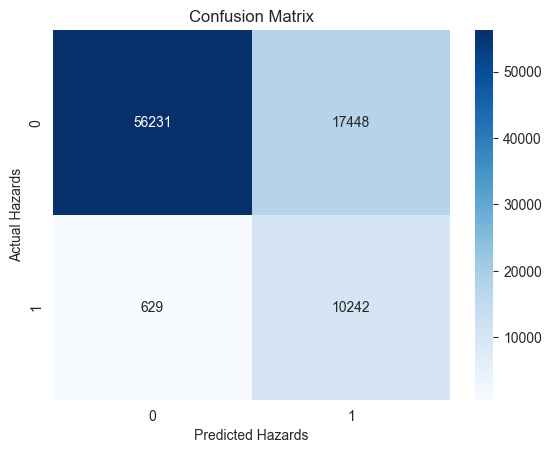

In [40]:
sns.heatmap(matrix, annot= True, fmt='d', cmap= 'Blues')

plt.xlabel("Predicted Hazards")
plt.ylabel("Actual Hazards")
plt.title("Confusion Matrix")

plt.show()


In [26]:
space_data_v1.to_csv("Space Data.csv", index=False)